---

# Add prerequisites

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import geopandas as gpd

---

# Load `overloads` .csv

In [21]:
df1 = pd.read_csv('357164042518400_OLs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time", "Channel1", "Channel2"])
df1.head(15).style.background_gradient('coolwarm')



,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,20210304,41113,11200,4736
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,20210304,41113,-11265,511
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,20210304,41114,12464,2303
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,20210304,41114,-11265,511
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,20210304,41114,11644,1464
5,60040,CANALE1,357164042518400,59.374608,17.997948,0.000000,20210304,41114,-12183,-129
6,60040,CANALE1,357164042518400,59.374606,17.997996,0.000000,20210304,41115,-12864,96
7,60040,CANALE1,357164042518400,59.374606,17.998020,0.000000,20210304,41115,12976,-1776
8,60040,CANALE1,357164042518400,59.374605,17.998046,0.000000,20210304,41115,-11104,1056
9,60040,CANALE1,357164042518400,59.374605,17.998049,0.000000,20210304,41115,-11192,-2240


---

# Pre-processing required (for overlods)

The acquired value is an integer number `[digit]` between 32768 and -32768. It can be converted
into a stress load using the sensitivity of 0.0068 `[MPa/digit]`. The absolute value is much more
important than the integer.

In [22]:
df1[['Channel1', 'Channel2']] = df1[['Channel1', 'Channel2']].apply(lambda x: abs(x * 0.0068), axis=1)
df1.head(15).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,20210304,41113,76.160000,32.204800
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,20210304,41113,76.602000,3.474800
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,20210304,41114,84.755200,15.660400
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,20210304,41114,76.602000,3.474800
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,20210304,41114,79.179200,9.955200
5,60040,CANALE1,357164042518400,59.374608,17.997948,0.000000,20210304,41114,82.844400,0.877200
6,60040,CANALE1,357164042518400,59.374606,17.997996,0.000000,20210304,41115,87.475200,0.652800
7,60040,CANALE1,357164042518400,59.374606,17.998020,0.000000,20210304,41115,88.236800,12.076800
8,60040,CANALE1,357164042518400,59.374605,17.998046,0.000000,20210304,41115,75.507200,7.180800
9,60040,CANALE1,357164042518400,59.374605,17.998049,0.000000,20210304,41115,76.105600,15.232000


### Change `Date` and `Time` to DateTime

In [23]:
df1['Time'] = df1['Time'].apply(lambda x: str(
    datetime.strptime(str(x), "%H%M%S").time()))
df1['Date'] = df1['Date'].apply(lambda x: str(
    datetime.strptime(str(x), "%Y%m%d").date()))
df1.head(5).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,2021-03-04,04:11:13,76.160000,32.204800
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,2021-03-04,04:11:13,76.602000,3.474800
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,2021-03-04,04:11:14,84.755200,15.660400
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,2021-03-04,04:11:14,76.602000,3.474800
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,2021-03-04,04:11:14,79.179200,9.955200


### Add new col `max_overload`

We have some unused column that tell us wich channel is sampling? so we combine three channels with one channel that name is `max_overload`

In [24]:
df1['max_overload'] = np.max(df1[['Channel1', 'Channel2']].values, axis=1)
df1.head(5).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,2021-03-04,04:11:13,76.160000,32.204800,76.160000
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,2021-03-04,04:11:13,76.602000,3.474800,76.602000
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,2021-03-04,04:11:14,84.755200,15.660400,84.755200
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,2021-03-04,04:11:14,76.602000,3.474800,76.602000
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,2021-03-04,04:11:14,79.179200,9.955200,79.179200


In [25]:
# x1 = df1
date_time = list(map(' '.join, df1[['Date', 'Time']].values.tolist()))
df1['Datetime'] = pd.to_datetime(pd.Series(date_time))
df1.head(5).style.background_gradient('coolwarm')

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,Datetime
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,2021-03-04,04:11:13,76.160000,32.204800,76.160000,2021-03-04 04:11:13
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,2021-03-04,04:11:13,76.602000,3.474800,76.602000,2021-03-04 04:11:13
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,2021-03-04,04:11:14,84.755200,15.660400,84.755200,2021-03-04 04:11:14
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,2021-03-04,04:11:14,76.602000,3.474800,76.602000,2021-03-04 04:11:14
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,2021-03-04,04:11:14,79.179200,9.955200,79.179200,2021-03-04 04:11:14


### Calculate distances

We want to see how much change in `latitude` and `longitude` is five meters?

In [26]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
lat1 = 53.32055555555556
lat2 = 53.31861111111111
lon1 = -1.7297222222222221
lon2 =  -1.6997222222222223
print(distance(lat1, lat2, lon1, lon2), "K.M")

2.0043678382716137 K.M


In [27]:
a = np.sqrt(np.sum((np.array([lat1, lon1]) - np.array([lat2, lon2]))**2))
b = distance(lat1, lat2, lon1, lon2) * 1000

five_meter_degree = (5 * a) / b
print(five_meter_degree)

7.49935909658473e-05


### Cluster near oveloads (<5m)

In [28]:
from sklearn.cluster import MeanShift

# mean_shift = MeanShift(bandwidth=five_meter_degree)

We cluster the coordinates in each `day`

In [29]:
unique_date = df1.Datetime.unique().astype(str).tolist()

clusters = []
adder = 0
for date in unique_date:
    temp = df1.loc[df1['Datetime'] == date]
    mean_shift = MeanShift(bandwidth=five_meter_degree)
    coordinates = temp[['Latitude', 'Longitude']].values
    mean_shift.fit(coordinates)
    l = mean_shift.labels_
    adder += (1 + max(l))
    clusters += (mean_shift.labels_ + adder).tolist()
    
df1_c = df1.copy()
df1_c['5m_cluster'] = clusters
df1_c

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,Datetime,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,2021-03-04 04:11:13,1
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,2021-03-04 04:11:13,1
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,2021-03-04 04:11:14,1
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,2021-03-04 04:11:14,1
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,2021-03-04 04:11:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796,76.4796,2021-11-08 23:09:41,1694
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096,78.0096,2021-11-08 23:09:41,1694
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496,76.6496,2021-11-08 23:09:41,1695
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,2021-11-08 23:09:43,1695


In [30]:
df1['5m_cluster'] = clusters
df1

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,Datetime,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,2021-03-04 04:11:13,1
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,2021-03-04 04:11:13,1
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,2021-03-04 04:11:14,1
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,2021-03-04 04:11:14,1
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,2021-03-04 04:11:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796,76.4796,2021-11-08 23:09:41,1694
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096,78.0096,2021-11-08 23:09:41,1694
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496,76.6496,2021-11-08 23:09:41,1695
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,2021-11-08 23:09:43,1695


In [31]:
# first calculate for one day
# coordinates = df1[['Latitude', 'Longitude']].values

In [32]:
# mean_shift.fit(coordinates)
# mean_shift.labels_

In [33]:
# df1['5m_cluster'] = mean_shift.labels_
# df1

---

# Load `Time seris` csv

In [34]:
    
df2 = pd.read_csv('357164042518400_THs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time"], skiprows=lambda x: x % 2 != 0)
df2['Time'] = df2['Time'].apply(lambda x: str(datetime.strptime(str(x), "%H%M%S").time()))
df2['Date'] = df2['Date'].apply(lambda x: str(datetime.strptime(str(x), "%Y%m%d").date()))
df2.head(15).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time
0,60040,CANALE1,357164042518400,59.372755,18.003537,0.000000,2021-03-04,04:12:15
1,60040,CANALE1,357164042518400,59.373505,18.002518,0.000000,2021-03-04,04:12:00
2,60040,CANALE1,357164042518400,59.373719,18.002101,0.000000,2021-03-04,04:11:54
3,60040,CANALE1,357164042518400,59.374128,18.001012,0.000000,2021-03-04,04:11:43
4,60040,CANALE1,357164042518400,59.372899,18.003275,0.000000,2021-03-04,04:12:12
5,60040,CANALE1,357164042518400,59.366946,18.007696,14.157340,2021-03-04,04:15:05
6,60040,CANALE1,357164042518400,59.365934,18.008505,0.000000,2021-03-04,04:15:16
7,60040,CANALE1,357164042518400,59.337029,18.038290,0.000000,2021-03-04,04:19:21
8,60040,CANALE1,357164042518400,57.817372,12.372347,0.000000,2021-03-06,05:15:43
9,60040,CANALE1,357164042518400,57.752946,12.218611,0.000000,2021-04-03,06:10:01


---

# Pre-processing required (for time series)

In [35]:
df3 = pd.read_csv('357164042518400_THs.csv', delimiter=';',
                  skiprows=lambda x: x % 2 == 0, names=list(range(5001)))
df4 = df3.abs().max(axis=1)
df2['time_series_overload'] = df4

In [36]:
df2[['time_series_overload']] = df2[['time_series_overload']].apply(
    lambda x: abs(x * 0.0068), axis=1)

df2.head(5).style.background_gradient('twilight_shifted_r')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,time_series_overload
0,60040,CANALE1,357164042518400,59.372755,18.003537,0.000000,2021-03-04,04:12:15,90.086400
1,60040,CANALE1,357164042518400,59.373505,18.002518,0.000000,2021-03-04,04:12:00,93.024000
2,60040,CANALE1,357164042518400,59.373719,18.002101,0.000000,2021-03-04,04:11:54,90.467200
3,60040,CANALE1,357164042518400,59.374128,18.001012,0.000000,2021-03-04,04:11:43,91.065600
4,60040,CANALE1,357164042518400,59.372899,18.003275,0.000000,2021-03-04,04:12:12,97.491600


### connect `time historys` to `overloads` **need to review**

In [16]:
# NEED TO REVIEW #
date_time_1 = df1[['Date', 'Time']].values.tolist()
date_time_2 = df2[['Date','Time']].values.tolist()

dt_1 = list(map(' '.join, date_time_1))
dt_2 = list(map(' '.join, date_time_2))
counter = 0
for date, overload1, coor1 in zip(dt_1, np.max(df1[['Channel1', 'Channel2']].values, axis=1).tolist(), df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2, coor2 in zip(dt_2, df2['time_series_overload'].values.tolist(), df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2 and coor1 == coor2:
            counter += 1
print(counter)

counter = 0
for date, overload1 in zip(dt_1, df1[['Latitude', 'Longitude']].values.tolist()):
    for d, overload2 in zip(dt_2, df2[['Latitude', 'Longitude']].values.tolist()):
        if date == d and overload1==overload2:
            counter += 1
print(counter)

390
481


In [45]:
df1_c = df1.copy()
df1_c.drop(['channel1', 'Channel2'])

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.0,2021-03-04,04:11:13,76.1600,32.2048,76.1600,76
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.0,2021-03-04,04:11:13,76.6020,3.4748,76.6020,76
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.0,2021-03-04,04:11:14,84.7552,15.6604,84.7552,76
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.0,2021-03-04,04:11:14,76.6020,3.4748,76.6020,76
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.0,2021-03-04,04:11:14,79.1792,9.9552,79.1792,76
...,...,...,...,...,...,...,...,...,...,...,...,...
12600,61040,CANALE2,357164042518400,59.376685,17.991453,0.0,2021-11-08,23:09:41,15.6740,76.4796,76.4796,275
12601,61040,CANALE2,357164042518400,59.376677,17.991481,0.0,2021-11-08,23:09:41,4.4608,78.0096,78.0096,275
12602,61040,CANALE2,357164042518400,59.376670,17.991506,0.0,2021-11-08,23:09:41,3.8080,76.6496,76.6496,275
12603,61040,CANALE2,357164042518400,59.376638,17.991621,0.0,2021-11-08,23:09:43,5.6576,75.7248,75.7248,714


In [17]:
mean_shift_2 = MeanShift(bandwidth=five_meter_degree)

mean_shift_2.fit(df2[['Latitude', 'Longitude']].values)
df2_clusters = mean_shift_2.labels_
print(df2_clusters)

[  7  42  39   2   6  50  54  59  95  97 256  96  98 254 252 251 152  45
 177 161 155 184  49 109 108 162   5  41  38   7   6  53  51  60 209   8
  62  47  44  40   2 181  65  72  68  27 121 120  21 103 105 102 106  20
  24  22  23  88  83 111 257 100 260 101  99 140 219 139 142 143 146  79
 195  58 187  48 157  12  35 159 160 166 145 135 193 194 217  74 210 179
 175   4   3 171 168 188  14  76 200 110 262  34 150 165  13   4   5  37
  15  71 249  82 230  81 228  11   0 127 131  10 118  64  19  70 214   9
   9  84  86  87  17  17  18  90 235 234  75 231  85 236  94  92  93 201
 205 223  89 240 239  91 246 183  55 149   1   1 123 122 191   8  77 212
  73  36 172  52  46  43   3  16  69  63  61  31 125  29  30  10  26 119
  56  57  66 197  80  25 224 226  12 222 144 137  33  78 147  11 130 113
  67 208 151 153   6  42  39   2   7  50  54  59 216  95 247 133  96  97
  98 255 253 250  45 174 173 164 163 185  49 115   6  38  41 170   5   7
  53  51  60  16   8  62  47 182  44  40   2  15  7

In [37]:
important_nodes = []
for cluster in np.unique(df1['5m_cluster'].values):
    important_nodes.append(df1.loc[df1['5m_cluster']==cluster].sort_values('max_overload', ascending=False).iloc[0].values.tolist())
  


In [38]:
important_nodes_df = pd.DataFrame(important_nodes, columns=df1.columns)
imp_coord = important_nodes_df[['Latitude', 'Longitude']].values
important_nodes_df.head(15).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,Datetime,5m_cluster
0,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,2021-03-04,04:11:14,84.755200,15.660400,84.755200,2021-03-04 04:11:14,1
1,60040,CANALE1,357164042518400,59.374604,17.998072,0.000000,2021-03-04,04:11:15,88.563200,11.315200,88.563200,2021-03-04 04:11:15,2
2,60040,CANALE1,357164042518400,59.374128,18.001012,0.000000,2021-03-04,04:11:43,91.065600,2.448000,91.065600,2021-03-04 04:11:43,3
3,60040,CANALE1,357164042518400,59.373728,18.002081,0.000000,2021-03-04,04:11:54,85.734400,15.232000,85.734400,2021-03-04 04:11:54,4
4,60040,CANALE1,357164042518400,59.373567,18.002423,0.000000,2021-03-04,04:11:58,91.827200,7.398400,91.827200,2021-03-04 04:11:58,5
5,60040,CANALE1,357164042518400,59.373505,18.002518,0.000000,2021-03-04,04:12:00,93.024000,13.110400,93.024000,2021-03-04 04:12:00,6
6,60040,CANALE1,357164042518400,59.372899,18.003275,0.000000,2021-03-04,04:12:12,97.491600,12.178800,97.491600,2021-03-04 04:12:12,7
7,60040,CANALE2,357164042518400,59.374611,17.997841,0.000000,2021-03-04,04:11:13,8.051200,82.905600,82.905600,2021-03-04 04:11:13,8
8,60040,CANALE2,357164042518400,59.374610,17.997888,0.000000,2021-03-04,04:11:14,1.958400,81.056000,81.056000,2021-03-04 04:11:14,9
9,60040,CANALE2,357164042518400,59.374603,17.998083,0.000000,2021-03-04,04:11:15,11.968000,89.760000,89.760000,2021-03-04 04:11:15,10


In [55]:
import geopandas as gpd
import matplotlib
import folium
# important_nodes_df['random'] = [list(range(1000)) for _ in range(len(important_nodes_df))]

gdf = gpd.GeoDataFrame(important_nodes_df.drop(['Datetime'], axis=1), geometry=gpd.points_from_xy(
    important_nodes_df.Longitude, important_nodes_df.Latitude))

# sweden_map = gpd.read_file('gis_map/test.shp')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = sweden_map.plot(figsize=(15, 15))
# gdf.plot(ax=ax, color='red')
m = world.explore()
gdf.explore(m=m, marker_type="circle_marker", color='red', marker_kwds={"radius": 5}, popup=['max_overload'])

### the variation of the overloads according to speed

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster
Sensor_id,1.000000,NaN,0.061417,-0.019832,-0.028443,0.195462,-0.211002,0.031581,0.017373
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.061417,NaN,1.000000,0.816730,-0.332558,0.005218,0.089722,0.420575,-0.372687
Longitude,-0.019832,NaN,0.816730,1.000000,-0.354333,-0.103438,0.154868,0.332865,-0.300730
Speed,-0.028443,NaN,-0.332558,-0.354333,1.000000,-0.072592,0.014206,-0.335865,0.440275
Channel1,0.195462,NaN,0.005218,-0.103438,-0.072592,1.000000,-0.961119,0.217794,-0.122085
Channel2,-0.211002,NaN,0.089722,0.154868,0.014206,-0.961119,1.000000,0.000927,-0.002127
max_overload,0.031581,NaN,0.420575,0.332865,-0.335865,0.217794,0.000927,1.000000,-0.637978
5m_cluster,0.017373,NaN,-0.372687,-0.300730,0.440275,-0.122085,-0.002127,-0.637978,1.000000


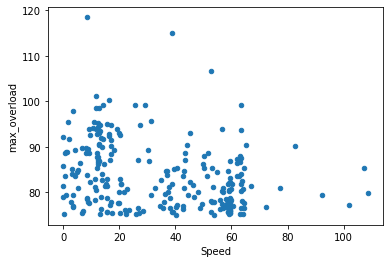

In [ ]:
important_nodes_df.where(0 < important_nodes_df['Speed']).plot.scatter('Speed', 'max_overload')
important_nodes_df.where(0 < important_nodes_df['Speed']).corr()

### the trend of the velocity

In [ ]:
# x1 = df1
df1_imp_copy = important_nodes_df.copy()
datetime = list(map(' '.join, df1_imp_copy[['Date', 'Time']].values.tolist()))
df1_imp_copy['Datetime'] = pd.to_datetime(pd.Series(datetime))
df1_imp_copy.head(15).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,geometry,Datetime
0,60040,CANALE2,357164042518400,59.507846,15.990516,0.000000,2021-07-06,09:26:46,5.657600,84.864000,84.864000,0,POINT (15.99051630020142 59.50784603118896),2021-07-06 09:26:46
1,61040,CANALE1,357164042518400,59.504811,15.988259,0.000000,2021-08-20,05:46:53,93.078400,0.000000,93.078400,1,POINT (15.9882593981587 59.50481093324944),2021-08-20 05:46:53
2,61040,CANALE1,357164042518400,59.597706,16.521523,0.069127,2021-09-07,08:58:10,85.734400,10.417600,85.734400,2,POINT (16.52152252197266 59.59770584106445),2021-09-07 08:58:10
3,60040,CANALE2,357164042518400,59.507988,15.990847,0.000000,2021-08-25,05:29:43,5.113600,86.278400,86.278400,3,POINT (15.99084666145736 59.50798767292201),2021-08-25 05:29:43
4,60040,CANALE2,357164042518400,59.505526,15.988311,0.000000,2021-07-06,09:26:33,4.678400,91.881600,91.881600,4,POINT (15.98831087589264 59.50552593231201),2021-07-06 09:26:33
5,61040,CANALE2,357164042518400,59.505607,15.988307,0.000000,2021-07-06,09:26:34,4.569600,91.174400,91.174400,5,POINT (15.98830676364899 59.50560668182373),2021-07-06 09:26:34
6,60040,CANALE2,357164042518400,59.372929,18.003097,0.000000,2021-04-27,04:02:52,8.921600,100.531200,100.531200,6,POINT (18.00309654998779 59.37292904663086),2021-04-27 04:02:52
7,60040,CANALE2,357164042518400,59.506211,15.988371,0.000000,2021-08-25,05:29:31,9.356800,86.822400,86.822400,7,POINT (15.98837128639221 59.50621082305909),2021-08-25 05:29:31
8,60040,CANALE2,357164042518400,59.506034,15.988319,0.000000,2021-08-25,05:29:30,9.730800,89.651200,89.651200,8,POINT (15.98831862336272 59.50603447760735),2021-08-25 05:29:30
9,61040,CANALE2,357164042518400,59.372966,18.003407,0.000000,2021-06-14,09:45:44,3.971200,105.808000,105.808000,9,POINT (18.00340673425696 59.37296584412292),2021-06-14 09:45:44


In [ ]:
# a = df1_copy['Datetime'].iloc[2] - df1_copy['Datetime'].iloc[1000]
# a.seconds
df1_imp_copy = df1_imp_copy.sort_values('Datetime')

In [ ]:
total_velocity = []
for date in np.unique(df1_imp_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_imp_copy.loc[df1_imp_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1_imp_copy['velocity'] = total_velocity
df1_imp_copy.head(15).style.background_gradient('coolwarm')

    

,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,geometry,Datetime,velocity
49,60040,CANALE2,357164042518400,59.373562,18.002432,0.000000,2021-03-04,04:11:58,2.828800,92.697600,92.697600,49,POINT (18.0024315071106 59.37356224060058),2021-03-04 04:11:58,0.000000
37,60040,CANALE2,357164042518400,59.373499,18.002525,0.000000,2021-03-04,04:12:00,3.454400,95.716800,95.716800,37,POINT (18.00252482414245 59.37349927902222),2021-03-04 04:12:00,12.866356
13,60040,CANALE2,357164042518400,59.373024,18.003133,0.000000,2021-03-04,04:12:09,6.092800,94.003200,94.003200,13,POINT (18.00313328933716 59.37302418518066),2021-03-04 04:12:09,20.361497
23,61040,CANALE1,357164042518400,59.372716,18.003608,0.000000,2021-03-04,04:12:16,95.458400,5.494400,95.458400,23,POINT (18.00360829775388 59.37271560607971),2021-03-04 04:12:16,19.148898
216,61040,CANALE2,357164042518400,59.372369,18.004204,0.000000,2021-03-04,04:12:23,2.393600,83.504000,83.504000,216,POINT (18.00420408630371 59.37236946105957),2021-03-04 04:12:23,23.293588
144,61040,CANALE1,357164042518400,59.367009,18.007650,13.977623,2021-03-04,04:15:05,90.086400,3.488400,90.086400,144,POINT (18.0076495541202 59.36700908192149),2021-03-04 04:15:05,9.435277
278,61040,CANALE2,357164042518400,59.366956,18.007688,14.130880,2021-03-04,04:15:05,8.268800,91.718400,91.718400,278,POINT (18.00768798828125 59.36695581054688),2021-03-04 04:15:05,157.666696
386,60040,CANALE2,357164042518400,59.366800,18.007810,14.553610,2021-03-04,04:15:06,3.529200,86.278400,86.278400,386,POINT (18.00780957221985 59.3667996711731),2021-03-04 04:15:06,43.180630
67,60040,CANALE2,357164042518400,59.365950,18.008490,0.000000,2021-03-04,04:15:16,2.665600,99.008000,99.008000,67,POINT (18.0084899597168 59.36594993591309),2021-03-04 04:15:16,25.869139
938,60040,CANALE2,357164042518400,59.334055,18.051649,15.452000,2021-03-04,04:21:17,4.297600,75.616000,75.616000,938,POINT (18.05164947509765 59.33405532836914),2021-03-04 04:21:17,35.671210


In [ ]:
important_nodes_df['velocity'] = total_velocity

In [ ]:
# Calculate velocity on complete data
df1_copy = df1.copy()
datetime = list(map(' '.join, df1_copy[['Date', 'Time']].values.tolist()))
df1_copy['Datetime'] = pd.to_datetime(pd.Series(datetime))

df1_copy = df1_copy.sort_values('Datetime')

total_velocity = []
for date in np.unique(df1_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_copy.loc[df1_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1['velocity'] = total_velocity
df1.head(15).style.background_gradient('coolwarm')


,Sensor_id,Channel,Device_id,Latitude,Longitude,Speed,Date,Time,Channel1,Channel2,max_overload,5m_cluster,velocity
0,60040,CANALE1,357164042518400,59.374611,17.997831,0.000000,2021-03-04,04:11:13,76.160000,32.204800,76.160000,76,0.000000
1,60040,CANALE1,357164042518400,59.374611,17.997852,0.000000,2021-03-04,04:11:13,76.602000,3.474800,76.602000,76,24.748819
2,60040,CANALE1,357164042518400,59.374611,17.997877,0.000000,2021-03-04,04:11:14,84.755200,15.660400,84.755200,76,6.065887
3,60040,CANALE1,357164042518400,59.374610,17.997900,0.000000,2021-03-04,04:11:14,76.602000,3.474800,76.602000,76,62.114683
4,60040,CANALE1,357164042518400,59.374609,17.997925,0.000000,2021-03-04,04:11:14,79.179200,9.955200,79.179200,76,89.047221
5,60040,CANALE1,357164042518400,59.374608,17.997948,0.000000,2021-03-04,04:11:14,82.844400,0.877200,82.844400,64,47.313919
6,60040,CANALE1,357164042518400,59.374606,17.997996,0.000000,2021-03-04,04:11:15,87.475200,0.652800,87.475200,64,20.949462
7,60040,CANALE1,357164042518400,59.374606,17.998020,0.000000,2021-03-04,04:11:15,88.236800,12.076800,88.236800,64,108.106374
8,60040,CANALE1,357164042518400,59.374605,17.998046,0.000000,2021-03-04,04:11:15,75.507200,7.180800,75.507200,64,62.340518
9,60040,CANALE1,357164042518400,59.374605,17.998049,0.000000,2021-03-04,04:11:15,76.105600,15.232000,76.105600,64,56.650709


### it is assumed that the higher velocity, the higher overload

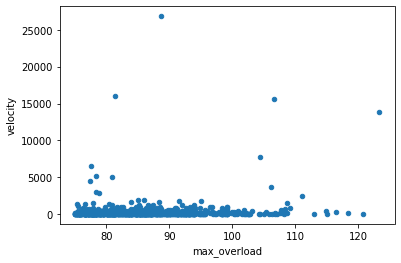

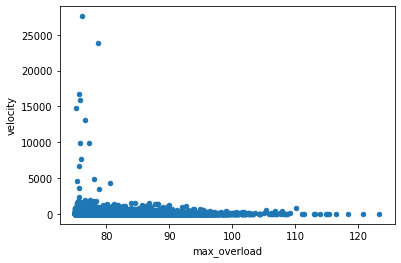

In [ ]:
important_nodes_df.plot.scatter('max_overload', 'velocity')
plt.show()

df1.plot.scatter('max_overload', 'velocity')
plt.show()

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


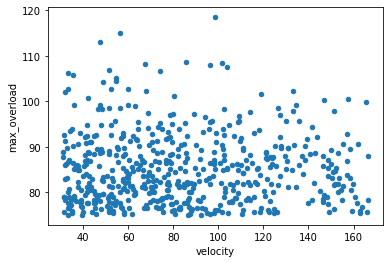

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


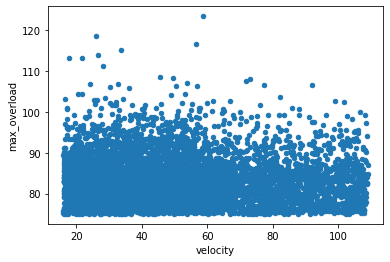

In [ ]:
print(df1['velocity'].describe())
important_nodes_df.where((31 < important_nodes_df['velocity'])& (important_nodes_df['velocity'] < 167), None).plot.scatter('velocity', 'max_overload')
plt.show()

print(df1['velocity'].describe())
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).plot.scatter('velocity', 'max_overload')
plt.show()

In [ ]:
important_nodes_df.corr()

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster,velocity
Sensor_id,1.000000,NaN,0.066279,0.014908,-0.032221,0.165218,-0.171897,0.013089,-0.019190,0.024498
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.066279,NaN,1.000000,0.733097,-0.194001,0.025083,0.033131,0.216047,-0.145055,0.042974
Longitude,0.014908,NaN,0.733097,1.000000,-0.128986,-0.016927,0.043315,0.174694,-0.155218,-0.005593
Speed,-0.032221,NaN,-0.194001,-0.128986,1.000000,-0.094175,0.049016,-0.215624,0.205488,0.052906
Channel1,0.165218,NaN,0.025083,-0.016927,-0.094175,1.000000,-0.956857,0.121355,0.008948,0.020346
Channel2,-0.171897,NaN,0.033131,0.043315,0.049016,-0.956857,1.000000,0.108303,-0.124470,0.012723
max_overload,0.013089,NaN,0.216047,0.174694,-0.215624,0.121355,0.108303,1.000000,-0.591345,0.111763
5m_cluster,-0.019190,NaN,-0.145055,-0.155218,0.205488,0.008948,-0.124470,-0.591345,1.000000,-0.057837
velocity,0.024498,NaN,0.042974,-0.005593,0.052906,0.020346,0.012723,0.111763,-0.057837,1.000000


In [ ]:
df1.corr()

,Sensor_id,Device_id,Latitude,Longitude,Speed,Channel1,Channel2,max_overload,5m_cluster,velocity
Sensor_id,1.000000,NaN,0.045795,0.002985,-0.009737,-0.013415,0.008011,0.001493,-0.036429,-0.036417
Device_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.045795,NaN,1.000000,0.731841,-0.162065,-0.014928,0.018798,0.042206,-0.244247,-0.074388
Longitude,0.002985,NaN,0.731841,1.000000,-0.128374,0.001726,0.015308,0.160407,-0.152551,-0.045568
Speed,-0.009737,NaN,-0.162065,-0.128374,1.000000,-0.015524,0.007806,-0.108481,0.333935,0.195037
Channel1,-0.013415,NaN,-0.014928,0.001726,-0.015524,1.000000,-0.961927,0.071683,0.011899,-0.000071
Channel2,0.008011,NaN,0.018798,0.015308,0.007806,-0.961927,1.000000,0.089077,-0.024321,-0.011550
max_overload,0.001493,NaN,0.042206,0.160407,-0.108481,0.071683,0.089077,1.000000,-0.137901,-0.061516
5m_cluster,-0.036429,NaN,-0.244247,-0.152551,0.333935,0.011899,-0.024321,-0.137901,1.000000,0.142887
velocity,-0.036417,NaN,-0.074388,-0.045568,0.195037,-0.000071,-0.011550,-0.061516,0.142887,1.000000


# Activites

## Summary statistics

In [ ]:
important_df = df1[['Channel', 'Time', 'Channel1', 'Channel2', 'max_overload', 'Speed']]
important_df.describe()

,Channel1,Channel2,max_overload,Speed
count,12605.00000,12605.000000,12605.000000,12605.000000
mean,49.74467,42.385125,82.896242,3.211854
std,37.23737,37.422452,5.521888,11.367294
min,0.00000,0.000000,75.010800,0.000000
25%,7.88800,6.201600,78.553600,0.000000
50%,76.37760,20.617600,82.252800,0.000000
75%,82.90560,81.328000,85.897600,0.000000
max,118.48320,123.379200,123.379200,108.599221


## Feature distributions

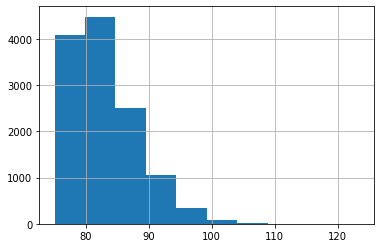

In [ ]:
df1['max_overload'].hist()
plt.show()

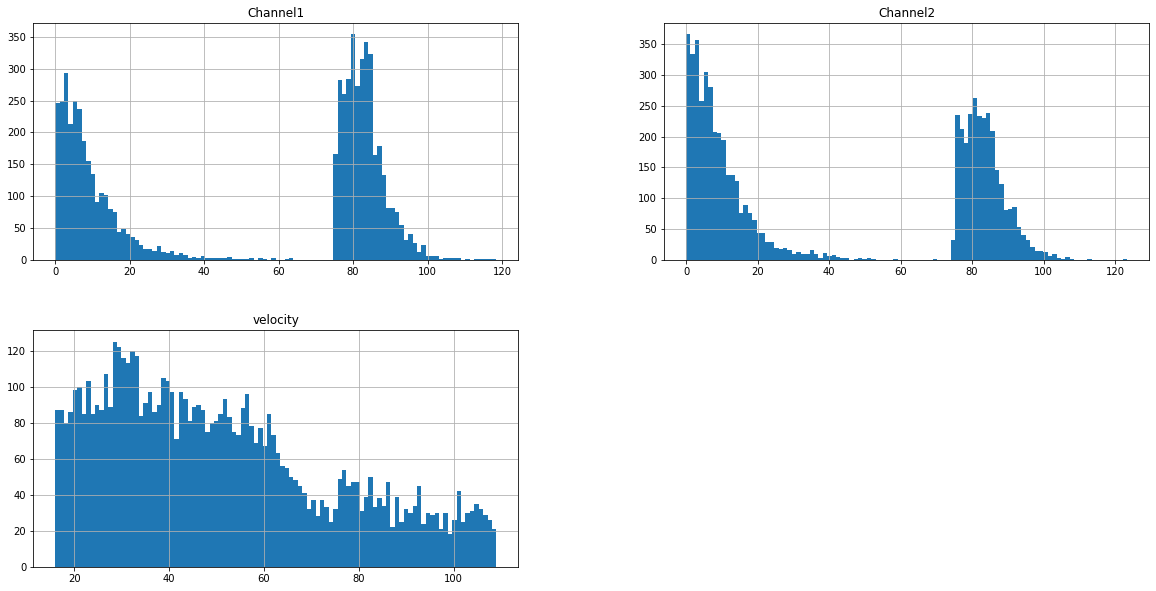

In [ ]:
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).hist(['Channel1', 'Channel2', 'velocity'], figsize=(20, 10), bins=100)  # Choose the 25% - 75% velocity 
plt.show()

In [ ]:
df1['velocity'].describe()

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64

In [ ]:
#add day of weak to our dataframe:

datetime = list(map(' '.join, df1[['Date', 'Time']].values.tolist()))
df1['Datetime'] = pd.to_datetime(pd.Series(datetime))
df1['day_of_weak'] = df1['Datetime'].dt.weekday
df1['day_of_weak'].value_counts()



4    3374
1    2621
2    2112
3    1571
5    1563
0     894
6     470
Name: day_of_weak, dtype: int64

## Feature correlations

### Plot a heatmap of correlations between features.

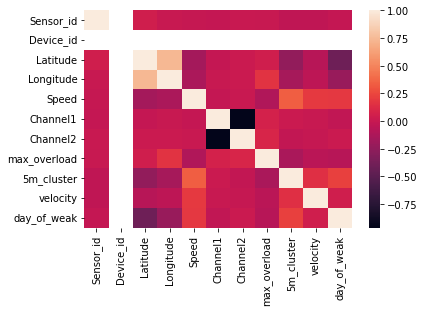

,Date,Time,max_overload,velocity,Latitude,Longitude
0,2021-03-04,04:11:13,76.160000,0.000000,59.374611,17.997831
1,2021-03-04,04:11:13,76.602000,24.748819,59.374611,17.997852
2,2021-03-04,04:11:14,84.755200,6.065887,59.374611,17.997877
3,2021-03-04,04:11:14,76.602000,62.114683,59.374610,17.997900
4,2021-03-04,04:11:14,79.179200,89.047221,59.374609,17.997925
5,2021-03-04,04:11:14,82.844400,47.313919,59.374608,17.997948
6,2021-03-04,04:11:15,87.475200,20.949462,59.374606,17.997996
7,2021-03-04,04:11:15,88.236800,108.106374,59.374606,17.998020
8,2021-03-04,04:11:15,75.507200,62.340518,59.374605,17.998046
9,2021-03-04,04:11:15,76.105600,56.650709,59.374605,17.998049


In [ ]:
import seaborn as sns
plt.figure()
correlation = df1.corr()
sns.heatmap(correlation)
plt.show()
df1
new_imp_df1 = df1[['Date','Time','max_overload','velocity','Latitude', 'Longitude']]
new_imp_df1.head(15).style.background_gradient('coolwarm')


### Are any of the columns highly correlated with one another? Can you explain the correlation?

**Answer:** No!

### E.g., is there Is there a relationship between the speed and the overload? If so, what is it?

**Answer:** they have a revirse relationship when speed is up our overload try to calm and say: man calm down take the easy ...

## Time series aspects

## Are there more overloads in winter or summer

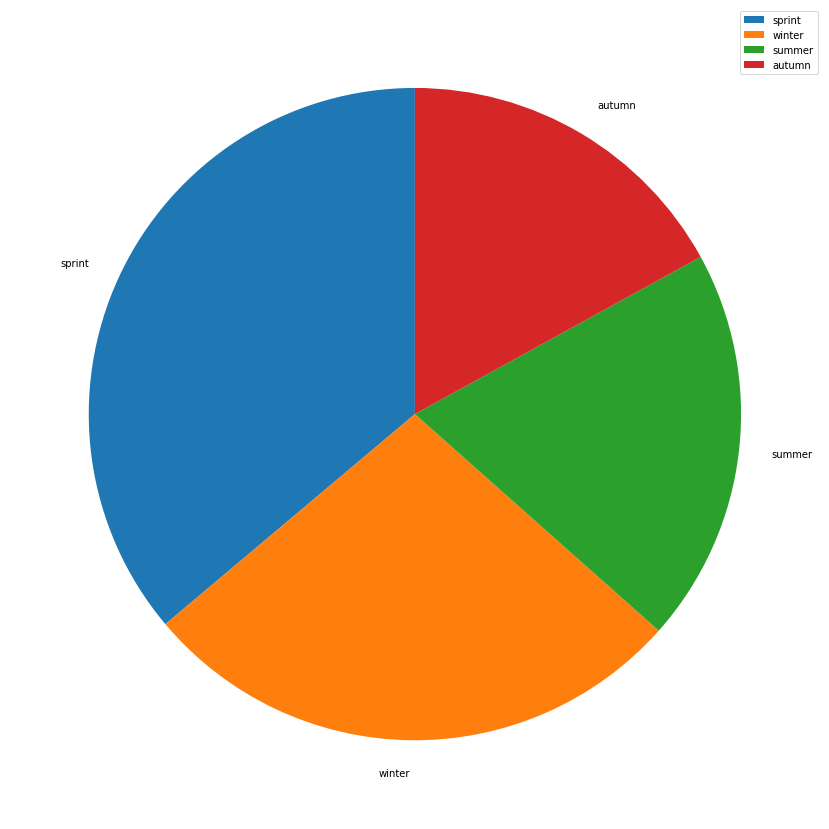

In [ ]:
# we add new feature and that is season ...
df1['season'] = df1['Datetime'].dt.month


def season_extractor(month):
    if 2 < month <= 5:
        return 'sprint'
    elif 6 < month <= 8:
        return 'summer'
    elif 8 < month <= 10:
        return 'autumn'
    else:
        return 'winter'


df1['season'] = df1['season'].apply(season_extractor)


plt.figure(figsize=(15, 15))

plt.pie(df1['season'].value_counts(), labels=df1['season'].unique() ,startangle=90)
plt.legend()
plt.show()


**Answer:** No this not true ...

### Which day of the week is more? Why?

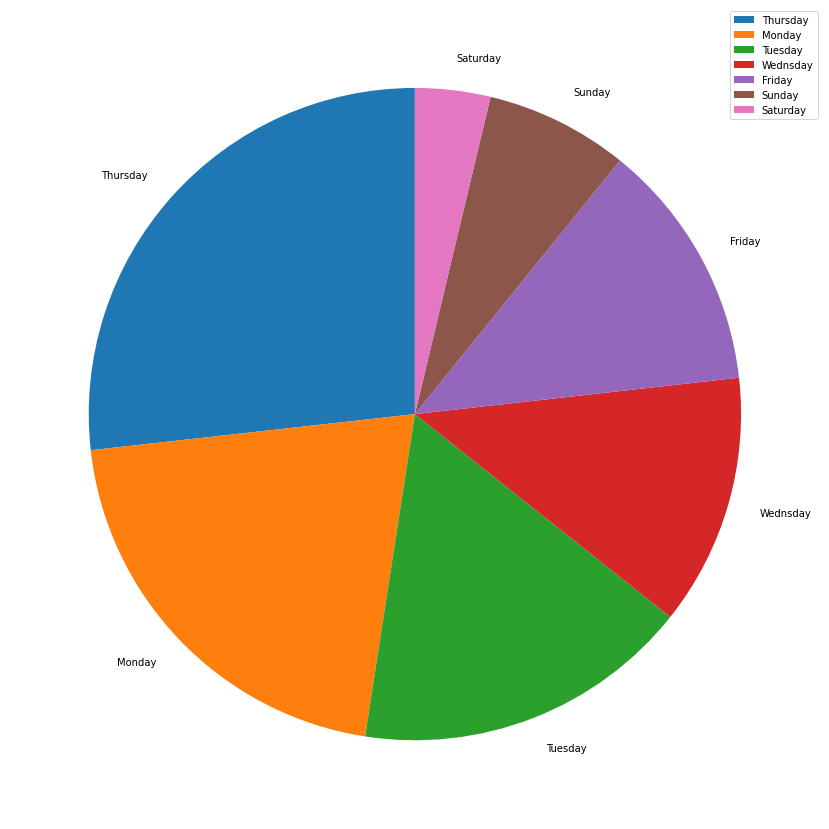

In [ ]:
plt.figure(figsize=(15, 15))

plt.pie(df1['day_of_weak'].value_counts(),
        labels=['Thursday', 'Monday', 'Tuesday', 'Wednsday', 'Friday', 'Sunday', 'Saturday'], startangle=90)
plt.legend()
plt.show()



**Answer:** Tuesday

### What time of day?

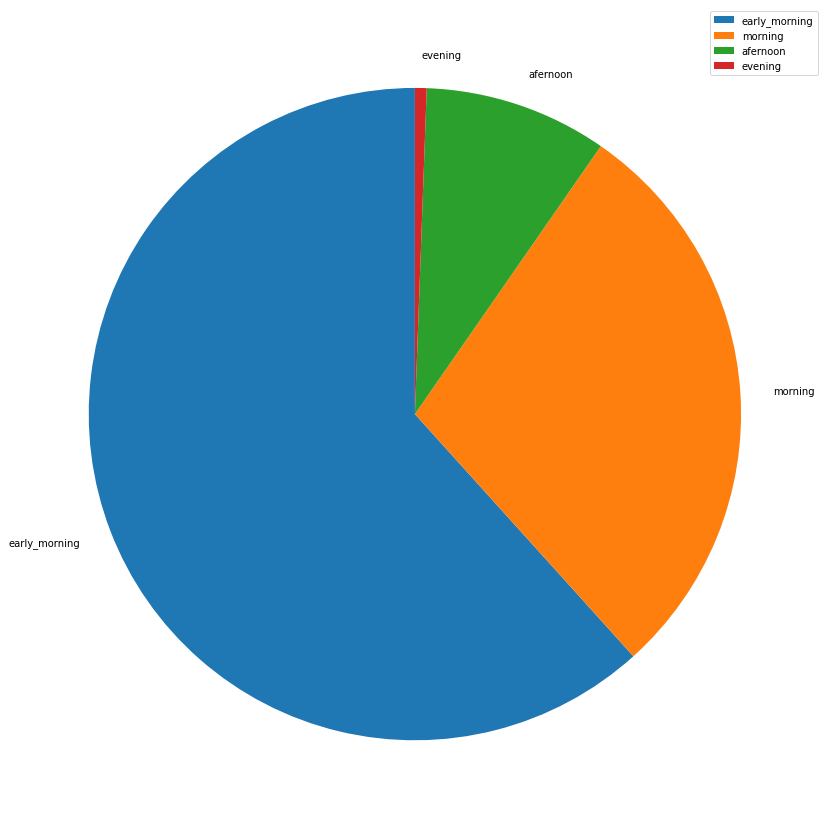

In [ ]:
def timeـclassification(val):
    val = int(val.split(':')[0])
    if val < 6:
        return 'early_morning'
    elif 6 <= val <= 12:
        return 'morning'
    elif 12 < val < 18:
        return 'afernoon'
    else:
        return 'evening'


df1['time_of_day'] = df1['Time'].apply(timeـclassification)
plt.figure(figsize=(15, 15))

plt.pie(df1['time_of_day'].value_counts(),
        labels=df1['time_of_day'].unique(), startangle=90)
plt.legend()
plt.show()



**Answer:** Early morning

## Spatial characteristics:

### Visualise the overloads data on a map.

**Answer:** we do that before.

### <i><s>Can you see any particular spatial features of the accidents?</i></s>

## <i><s>Contributing factors and overloads</i></s>